In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import optax
from localization import datasets, models, samplers
from localization.experiments import simulate_or_load, load, make_key

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  batch_size=1000,
  support=(-1, 1), # defunct
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1.,
  # learning config
  num_epochs=5000,
  evaluation_interval=10,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  wandb_=False,
  # EXTRA
  num_hiddens=(1, 40,)[1],
  activation=('relu', 'sigmoid',)[1],
  use_bias=(True, False,)[0],
  learning_rate=(1.0, 0.025, 20.0, 0.5,)[2],
  gain=np.linspace(0.01, 5, 10)[2],
)

In [2]:
def track_top_n_overlap(argsort, n=5):
    num_steps, num_inputs = argsort.shape
    ind = slice(-n, None) if n > 0 else slice(None, -n)
    final_rank = argsort[-1,ind]
    return np.array([[ i in final_rank for i in argsort[t,ind] ] for t in range(num_steps)])

def track_top_n_single(argsort, n=5):
    num_steps, num_inputs = argsort.shape
    ind = slice(-n, None) if n > 0 else slice(None, n)
    final_rank = argsort[-1,-1] if n > 0 else argsort[-1,0]
    return np.array([ final_rank in argsort[t,ind] for t in range(num_steps)])

def track_weights(weights, n=5):
    # get ranking of positions for each neuron across time
    # greatest magnitude weights have largest value
    argsort = np.argsort(weights, axis=-1)
    
    # track consistency of top n positions across time
    is_pos = weights[-1].max(axis=1) > -weights[-1].min(axis=1)
    n_ = (2 * is_pos.astype(int) - 1) * n
    top_n_overlap =  np.mean(np.stack([ track_top_n_overlap(argsort[:,i,:], n=ni) for i, ni in enumerate(n_) ], axis=1), axis=2)
    top_n_single = np.stack([ track_top_n_single(argsort[:,i,:], n=ni) for i, ni in enumerate(n_) ], axis=1)
    
    return top_n_overlap, top_n_single

def track_peaks(n=5, **config):
    """This function sees how well the Gaussian approximation can predict the peaks of the non-Gaussian weights."""
    # load weights
    weights_nlgp, metrics_nlgp = load(**config, dataset_cls=datasets.NonlinearGPDataset)
    weights_gauss, metrics_gauss = load(**config, dataset_cls=datasets.NLGPGaussianCloneDataset)

    is_loc = metrics_nlgp[-1,3] < 0
    
    weights_nlgp = weights_nlgp[:,is_loc]
    weights_gauss = weights_gauss[:,is_loc]

    # get error between NLGP and Gaussian clone
    err = np.sqrt(np.mean(np.square(weights_nlgp - weights_gauss), axis=(2,)))
    err = np.mean(err, axis=1) / np.mean(np.sqrt((weights_nlgp**2).mean(axis=2)))
    
    # track peaks
    overlap, single = track_weights(weights_nlgp, n=n)

    # plot results
    fig, ((ax1, ax2, ax_), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(16, 10))
    epochs_nlgp, epochs_gauss = metrics_nlgp[:,0], metrics_gauss[:,0]
    # plot losses
    ax1.plot(epochs_nlgp, metrics_nlgp[:,1], label='NLGP')
    ax1.plot(epochs_gauss, metrics_gauss[:,1], label='Gaussian clone')
    ax1.set_xscale('log')
    ax1.set_title('Loss')
    ax1.legend()
    # plot accuracies
    ax2.plot(epochs_nlgp, metrics_nlgp[:,2], label='NLGP')
    ax2.plot(epochs_gauss, metrics_gauss[:,2], label='Gaussian clone')
    ax2.set_xscale('log')
    ax2.set_title('Accuracy')
    ax2.legend()
    # hide ax_
    ax_.axis('off')
    # plot error
    ax3.plot(epochs_nlgp, err)
    ax3.set_title('Approximation Error')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    # plot peak tracking, overlap
    ax4.plot(epochs_nlgp, overlap)
    ax4.set_xscale('log')
    ax4.set_title(f'Overlap among top {n}')
    # plot peak tracking, single
    ax5.plot(epochs_nlgp, single)
    ax5.set_xscale('log')
    ax5.set_title(f'Final peak in top {n}')
    
    return fig, ((ax1, ax2, ax_), (ax3, ax4, ax5)), (weights_nlgp, metrics_nlgp), (weights_gauss, metrics_gauss)

Already simulated
Already simulated


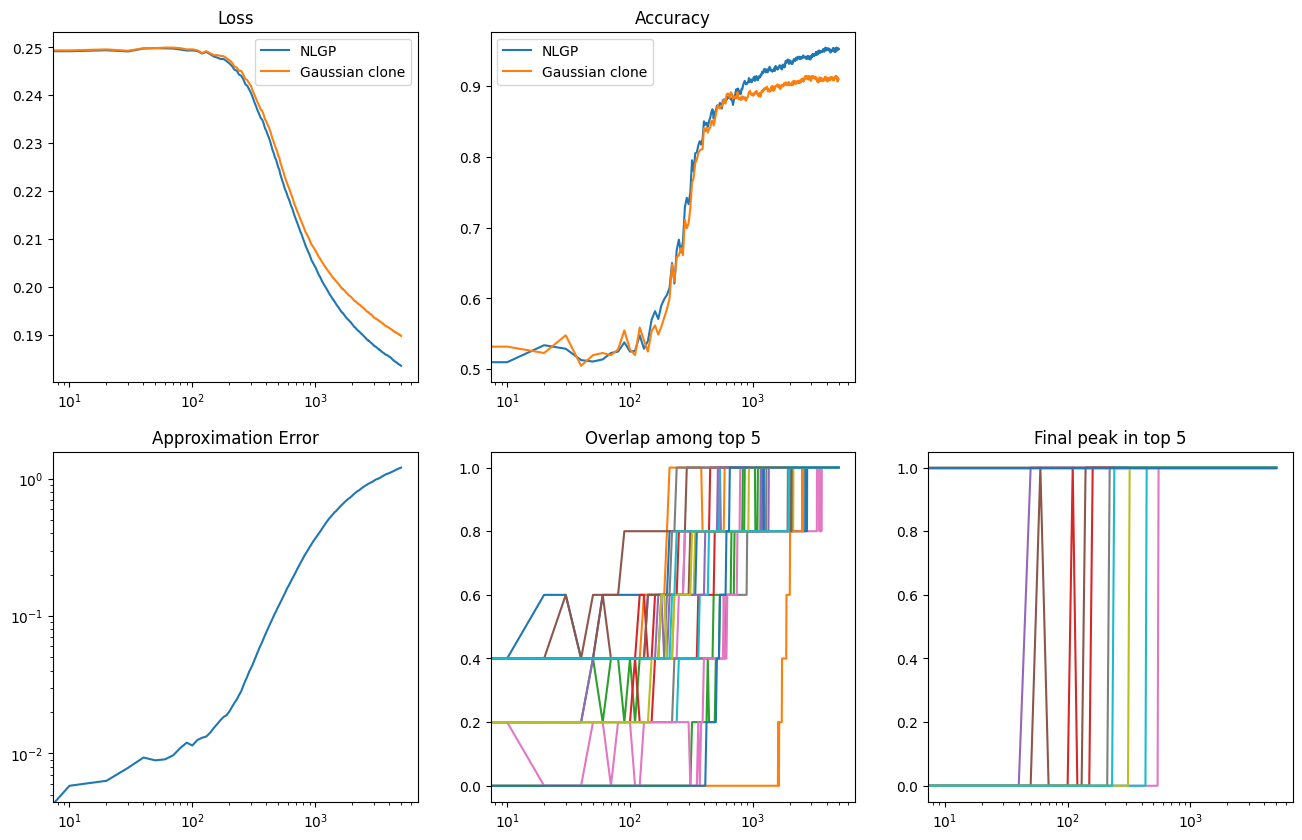

In [3]:
fig, axs, (weights_nlgp, metrics_nlgp), (weights_gauss, metrics_gauss) = track_peaks(**config_)

In [4]:
"""This function sees how well the Gaussian approximation can predict the peaks of the non-Gaussian weights."""
# load weights
config = config_.copy()
n = 5
weights_nlgp, metrics_nlgp = load(**config, dataset_cls=datasets.NonlinearGPDataset)
weights_gauss, metrics_gauss = load(**config, dataset_cls=datasets.NLGPGaussianCloneDataset)

is_loc = metrics_nlgp[-1,3] < 0

weights_nlgp = weights_nlgp[:,is_loc]
weights_gauss = weights_gauss[:,is_loc]

# get error between NLGP and Gaussian clone
err = np.sqrt(np.mean(np.square(weights_nlgp - weights_gauss), axis=(2,)))
err = np.mean(err, axis=1) #/ np.mean(np.sqrt((weights_nlgp**2).mean(axis=2)))

# track peaks
overlap, single = track_weights(weights_nlgp, n=n)

Already simulated
Already simulated


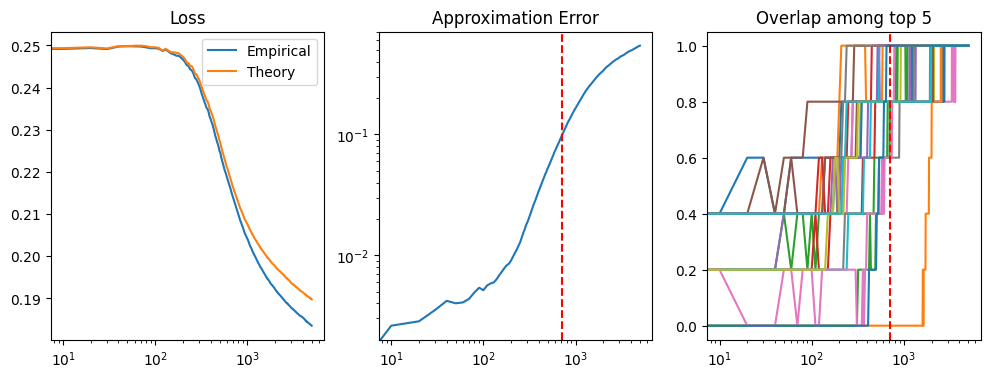

In [10]:
# plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
epochs_nlgp, epochs_gauss = metrics_nlgp[:,0], metrics_gauss[:,0]
# plot losses
ax1.plot(epochs_nlgp, metrics_nlgp[:,1], label='Empirical')
ax1.plot(epochs_gauss, metrics_gauss[:,1], label='Theory')
ax1.set_xscale('log')
ax1.set_title('Loss')
ax1.legend()
# plot accuracies
# ax2.plot(epochs_nlgp, metrics_nlgp[:,2], label='NLGP')
# ax2.plot(epochs_gauss, metrics_gauss[:,2], label='Gaussian clone')
# ax2.set_xscale('log')
# ax2.set_title('Accuracy')
# ax2.legend()
# hide ax_
# ax_.axis('off')
# plot error
ax2.plot(epochs_nlgp, err)
ax2.set_title('Approximation Error')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.axvline(epochs_nlgp[np.where(err <= 0.1)[0][-1]], color='r', linestyle='--')
# plot peak tracking, overlap
ax3.plot(epochs_nlgp, overlap)
ax3.set_xscale('log')
ax3.set_title(f'Overlap among top {n}')
ax3.axvline(epochs_nlgp[np.where(err <= 0.1)[0][-1]], color='r', linestyle='--')
# plot peak tracking, single
# ax3.plot(epochs_nlgp, single)
# ax3.set_xscale('log')
# ax3.set_title(f'Final peak in top {n}')

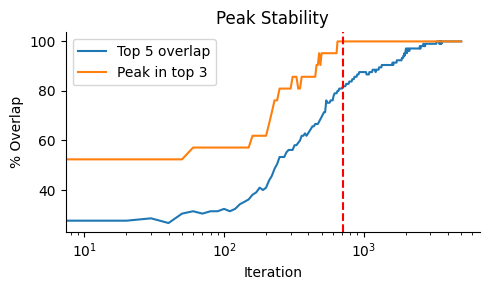

In [25]:
# plot results
fig, ax3 = plt.subplots(1, 1, figsize=(5, 3))
epochs_nlgp, epochs_gauss = metrics_nlgp[:,0], metrics_gauss[:,0]
# # plot losses
# ax1.plot(epochs_nlgp, metrics_nlgp[:,1], label='Empirical')
# ax1.plot(epochs_gauss, metrics_gauss[:,1], label='Theory')
# ax1.set_xscale('log')
# ax1.set_title('Loss Dynamics')
# ax1.legend()
# # ax_.axis('off')
# ax1.axvline(epochs_nlgp[np.where(err <= 0.1)[0][-1]], color='r', linestyle='--')
# ax1.set_xlabel('Iteration')
# ax1.set_ylabel('Prediction Loss')
# plot error
# ax2.plot(epochs_nlgp, err)
# ax2.set_title('Approximation Error')
# ax2.set_xscale('log')
# ax2.set_yscale('log')
# ax2.axvline(epochs_nlgp[np.where(err <= 0.1)[0][-1]], color='r', linestyle='--')
# plot peak tracking, overlap
overlap5 = overlap
# single3 = single
ax3.plot(epochs_nlgp, 100 * overlap5.mean(axis=1), label='Top 5 overlap')
ax3.plot(epochs_nlgp, 100 * single3.mean(axis=1), label='Peak in top 3')
ax3.set_xscale('log')
ax3.set_title('Peak Stability')
ax3.axvline(epochs_nlgp[np.where(err <= 0.1)[0][-1]], color='r', linestyle='--')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('% Overlap')
ax3.legend()

for ax in (ax1, ax3):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()

In [26]:
fig.savefig('peaks.png', dpi=300, bbox_inches='tight')

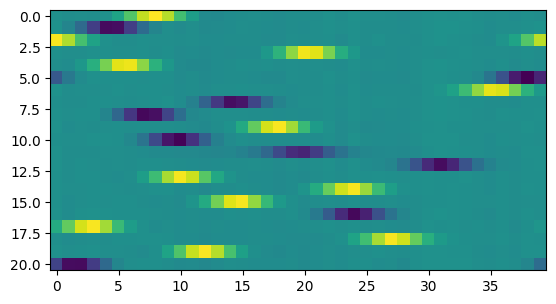

In [26]:
plt.imshow( weights_nlgp[-1, metrics_nlgp[-1,3] < 0] )

### Fourier transform

In [207]:
from localization.utils import plot_rf_evolution

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  batch_size=1000,
  support=(-1, 1), # defunct
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=0.01,
  # learning config
  num_epochs=5000,#5000,
  evaluation_interval=100,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  wandb_=False,
  # EXTRA
  num_hiddens=(1, 5, 10, 20, 40,)[-3],
  activation=('relu', 'sigmoid',)[1],
  use_bias=(True, False,)[0],
  learning_rate=(1.0, 0.025, 20.0, 0.5, 40.0)[-1],
  gain=np.linspace(0.01, 5, 10)[2],
)
weights_nlgp, metrics_nlgp = simulate_or_load(**config_, dataset_cls=datasets.NonlinearGPDataset)
weights_gauss, metrics_gauss = simulate_or_load(**config_, dataset_cls=datasets.NLGPGaussianCloneDataset)

Already simulated
Already simulated


In [208]:
low_gauss = weights_gauss[:,np.abs(np.fft.fft(weights_gauss[-1])).sum(axis=1) < 150]
low_nlgp = weights_nlgp[:,np.abs(np.fft.fft(weights_nlgp[-1])).sum(axis=1) < 150]

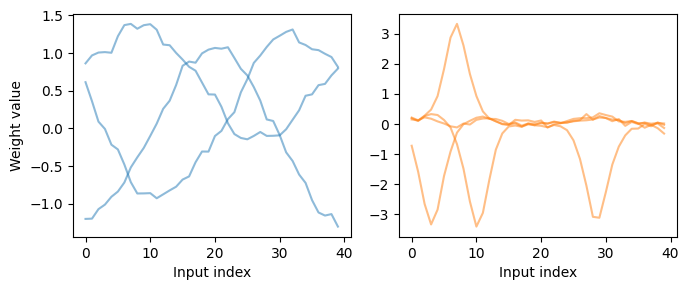

In [209]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
_ = ax1.plot(low_gauss[-1,:3].T, color='tab:blue', alpha=0.5)
_ = ax2.plot(low_nlgp[-1].T, color='tab:orange', alpha=0.5)
ax1.set_xlabel('Input index'); ax2.set_xlabel('Input index')
ax1.set_ylabel('Weight value')
fig.tight_layout()
# fig.savefig('weight_viz.png', dpi=300)

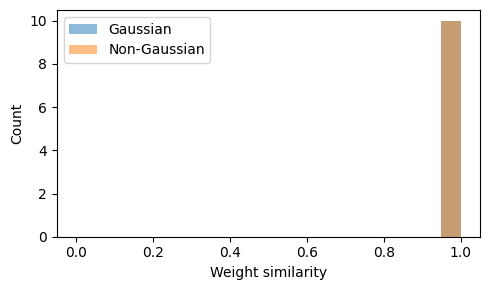

In [210]:
def get_sims(weights):
    w = weights - weights.mean(axis=2, keepdims=True)
    w = w * np.sign([ w[-1][i, m] for i, m in enumerate(np.argmax(np.abs(w[-1]), axis=1)) ]).reshape(1, -1, 1)
    u = np.abs(np.fft.fft(w[-1]))
    norm = np.linalg.norm(u, axis=1, keepdims=True)
    v = np.triu(u @ u.T / ( norm @ norm.T ))
    return w, v[v > 0]

w_noise = np.random.normal(size=low_gauss.shape)
adj_gauss, sims_gauss = get_sims(low_gauss)
adj_nlgp, sims_nlgp = get_sims(low_nlgp)
# sim_noise = get_sims(w_noise)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
bins = np.linspace(0, 1, 20)
ax.hist(sims_gauss, bins=bins, alpha=0.5, label='Gaussian', density=False)
ax.hist(sims_nlgp, bins=bins, alpha=0.5, label='Non-Gaussian', density=False)
# ax.hist(sim_noise, bins=bins, alpha=0.5, label='Noise', density=False)
ax.legend()
ax.set_xlabel('Weight similarity')
ax.set_ylabel('Count')
fig.tight_layout()
# fig.savefig('weight_similarity.png', dpi=300)

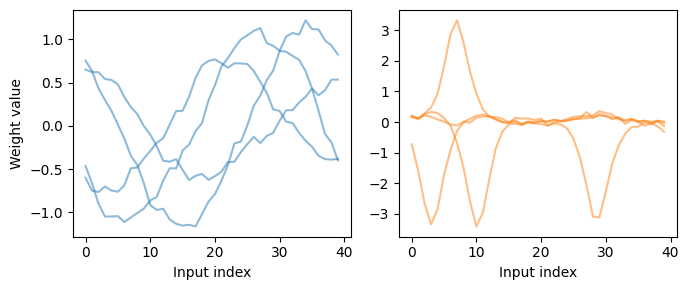

In [215]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
_ = ax1.plot(np.roll(adj_gauss[-1].T, -20), color='tab:blue', alpha=0.5)
_ = ax2.plot(low_nlgp[-1].T, color='tab:orange', alpha=0.5)
ax1.set_xlabel('Input index'); ax2.set_xlabel('Input index')
ax1.set_ylabel('Weight value')
fig.tight_layout()
fig.savefig('weight_viz2.png', dpi=300)

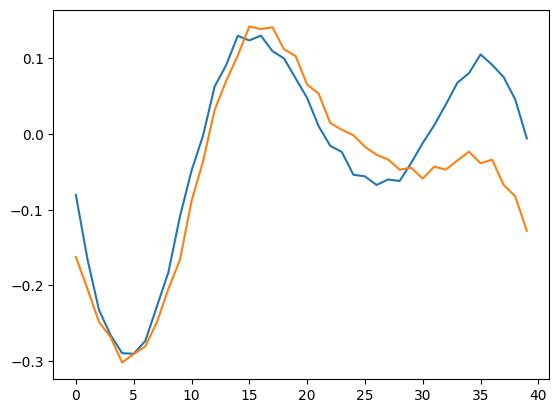

In [42]:
w0 = weights_gauss[-1,1]
w1 = np.roll(-weights_gauss[-1,2], -5) - 0.075
_ = plt.plot(w0)
_ = plt.plot(w1)

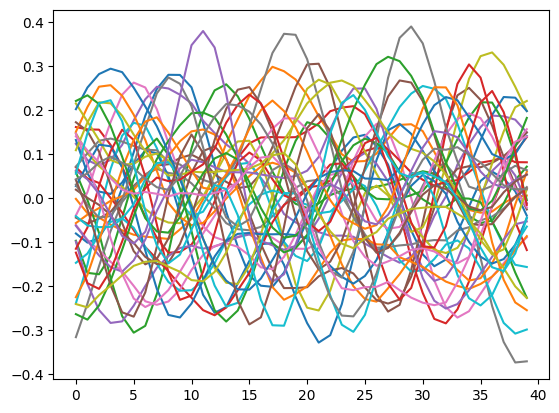

In [89]:
_ = plt.plot(weights_gauss[-1].T)

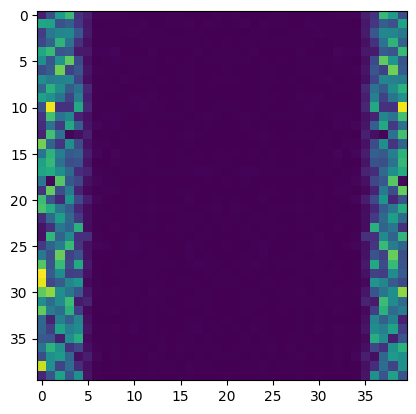

In [33]:
_ = plt.imshow( np.abs(np.fft.fft(weights_gauss[-1])) )

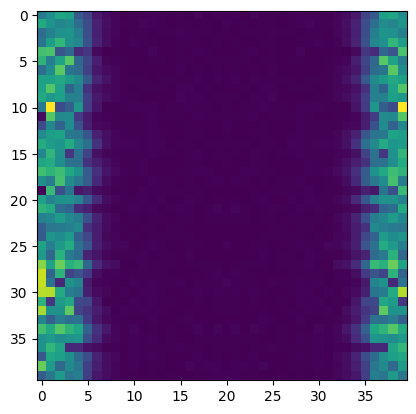

In [36]:
_ = plt.imshow( np.abs(np.fft.fft(weights_nlgp[-1])) )

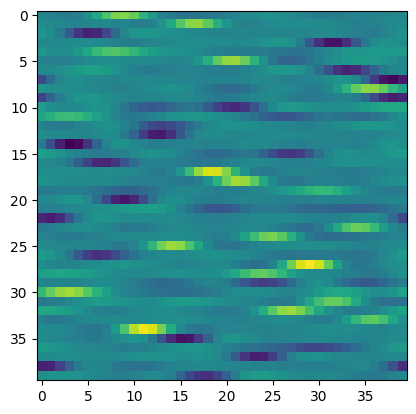

In [34]:
_ = plt.imshow(weights_nlgp[-1])

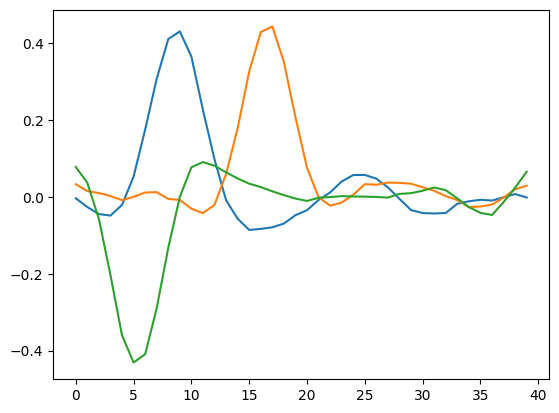

In [35]:
_ = plt.plot(weights_nlgp[-1,:3].T)

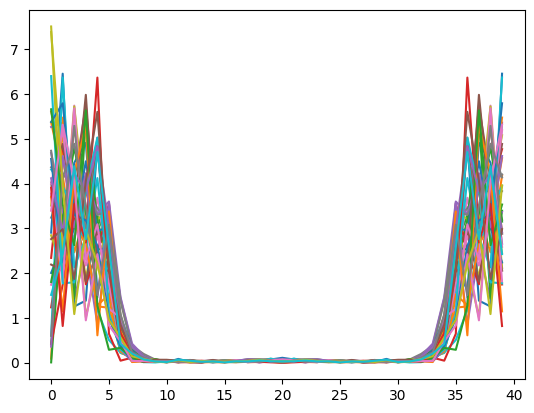

In [20]:
_ = plt.plot( np.abs(np.fft.fft(weights_nlgp[-1])).T )

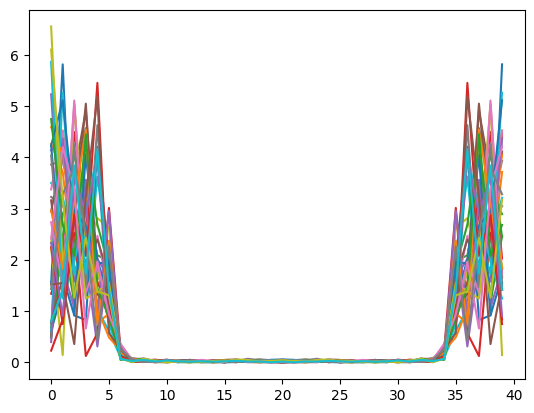

In [23]:
_ = plt.plot( np.abs(np.fft.fft(weights_gauss[-1])).T )